In [31]:
import nltk
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize 

master_videos = pd.read_parquet("/Users/jesustellez/Desktop/aiDynamics/API Data extraction/Data/l1/m_videos.parquet")
master_tags = pd.read_csv("/Users/jesustellez/Desktop/aiDynamics/API Data extraction/Data/l1/m_tags.csv")
fact_comments = pd.read_parquet("/Users/jesustellez/Desktop/aiDynamics/API Data extraction/Data/l1/fact_comments_rated.parquet")

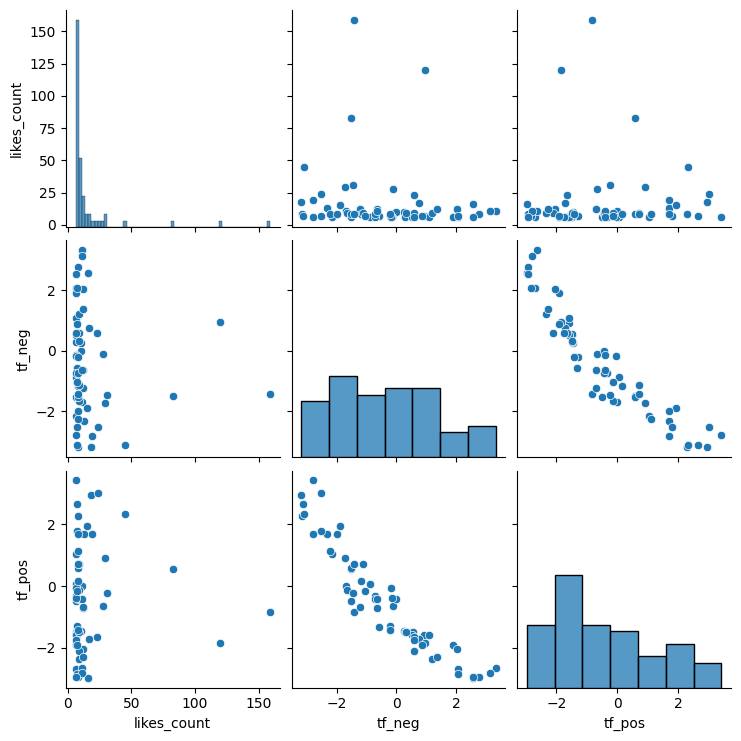

In [12]:
sns.pairplot(
    data=fact_comments[(fact_comments["categorie"]=="war") & (fact_comments["likes_count"]>5)], 
    vars = ["likes_count", "tf_neg", "tf_pos"]
)
plt.show()


In [48]:
user_analysis = (
    fact_comments.groupby(["author_name"], as_index=False)
    .agg(total_comments = pd.NamedAgg(column="comment_id", aggfunc ="count"),
        total_likes = pd.NamedAgg(column="likes_count", aggfunc ="sum"),
        neg_mean = pd.NamedAgg(column="tf_neg", aggfunc ="mean"),
        neu_mean = pd.NamedAgg(column="tf_neu", aggfunc ="mean"),
        pos_mean = pd.NamedAgg(column="tf_pos", aggfunc ="mean")
        )
    .assign(BEHAVIOURAL = lambda x: user_analysis[["neg_mean", "pos_mean"]].max(axis=1))
).sort_values(by="total_likes", ascending=False)[:1000]

#user_analysis["behavioural"] = "neg_mean"+"pos_mean"

In [49]:
user_analysis

,author_name,total_comments,total_likes,neg_mean,neu_mean,pos_mean,BEHAVIOURAL
4847,Scott Tunbridge,5,998.0,-3.121355,0.842143,2.312304,2.312304
3779,Mitchel,3,322.0,0.911699,0.749741,-1.785858,0.911699
2793,Jordan Pilapil,2,318.0,-1.425316,2.141996,-0.827012,-0.827012
5890,Yasmin Wade,3,249.0,-1.514175,0.716125,0.561673,0.561673
4786,Samanthwalter Archie,2,240.0,0.944141,0.702091,-1.843721,0.944141
...,...,...,...,...,...,...,...
3046,Kiaxiro,3,3.0,-0.249911,1.271663,-1.060545,-0.249911
2664,Joe,6,3.0,-0.589135,0.886525,-0.287561,-0.287561
5395,TheWatchernator,1,3.0,-1.553149,1.524285,0.025049,0.025049
4951,SickofRed,1,3.0,-0.471289,0.654611,-0.290654,-0.290654


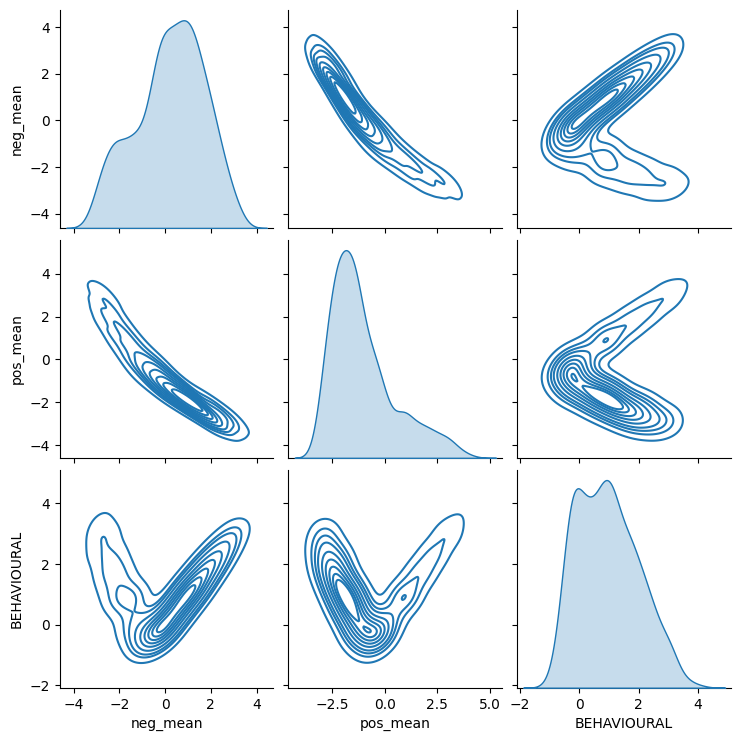

In [50]:
sns.pairplot(
    data=user_analysis, 
    vars = ["neg_mean","pos_mean" ,"BEHAVIOURAL"],
    kind = "kde"
)
plt.show()

In [135]:
conditions = [
    (fact_comments['likes_count'] == 0),
    (fact_comments['likes_count'] > 0) & (fact_comments['likes_count'] <= 5),
    (fact_comments['likes_count'] > 5)
    ]

values = ['LowLikes', 'MediumLikes', 'HighLikes']

fact_comments['categoryComment'] = np.select(conditions, values)

aux_comments = fact_comments[["video_id", "comment_id", "author_name","categorie" ,"test_display_aux", "likes_count","categoryComment" ,"tf_neg", "tf_neu", "tf_pos"]]

word_analysis = aux_comments.sort_values(by="likes_count", ascending=False)
word_analysis["word"] = word_analysis["test_display_aux"].apply(word_tokenize)
word_analysis = word_analysis.explode("word")
word_analysis = word_analysis.groupby(["word","categorie", "categoryComment"], as_index=False).agg(
    metric_likes = pd.NamedAgg(column="likes_count", aggfunc="mean"),
    metric_counts = pd.NamedAgg(column="word", aggfunc="count")
).sort_values(by="metric_counts", ascending=False)
word_analysis["metric"]= word_analysis.metric_counts/len(word_analysis)*(word_analysis.metric_likes+1)

word_analysis = word_analysis.sort_values(by="metric", ascending=False)

In [225]:
auxiliar = word_analysis.groupby(["categorie","categoryComment"], as_index=False).count()[["categorie", "categoryComment", "word"]]

ratesCat = list()
for i in auxiliar.categorie.unique():
    totalwords = sum(auxiliar[auxiliar["categorie"]==i].word)
    rate = np.array(auxiliar[auxiliar["categorie"]==i].word/totalwords*100)[np.newaxis].T
    #rate = np.transpose(rate)
    ratesCat.append(rate)

ratesCat = pd.DataFrame(ratesCat)
#auxiliar
    

/Users/jesustellez/Desktop/aiDynamics/API Data extraction/l1_youtubemodel/.env/lib/python3.10/site-packages/pandas/core/internals/construction.py:576: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [227]:
ratesCat

,0
0,"[[0.022977941176470586], [2.458639705882353], ..."
1,"[[3.215434083601286], [67.09539121114683], [29..."
2,"[[0.2757564151666028], [5.292991191114515], [6..."
3,"[[0.4055351997438725], [4.041122692184554], [6..."
4,"[[7.444886158294181], [59.559089266353446], [3..."
5,"[[0.2554278416347382], [4.054916985951468], [5..."
6,"[[0.09567089213106912], [0.597943075819182], [..."
7,"[[0.23351391742947877], [3.1571081636465532], ..."


In [138]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

aux_word_analysis = word_analysis[word_analysis["categorie"]=="politics"]
aux_word_analysis_ll = aux_word_analysis[aux_word_analysis["categoryComment"]=="LowLikes"]
aux_word_analysis_ml = aux_word_analysis[aux_word_analysis["categoryComment"]=="MediumLikes"]
aux_word_analysis_hl = aux_word_analysis[aux_word_analysis["categoryComment"]=="HighLiks"]

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=aux_word_analysis_ll["word"], 
        y=aux_word_analysis_ll["metric"], 
        name='LowLikes',
        marker_color='red'))

"""fig.add_trace(
    go.Bar(
        x=aux_word_analysis_ml["word"], 
        y=aux_word_analysis_ml["metric"], 
        name='MediumLikes',
        marker_color='yellow'))"""

fig.add_trace(
    go.Bar(
        x=aux_word_analysis_hl["word"], 
        y=aux_word_analysis_hl["metric"], 
        name='HighLikes',
        marker_color='blue'))

fig.show()

In [123]:
for i in word_analysis.categorie.unique():
    context = word_analysis[word_analysis["categorie"]==i][:30].sort_values(by="metric").dropna()
    fig = go.Figure()
    fig.add_trace(go.Bar(x=context["word"], y=context["metric"]))
    fig.update_layout(
        title=i,
        xaxis_title="Most Repeated words",
        yaxis_title="Metric")
    fig.show()

In [121]:
word_analysis.dropna()

,word,categorie,metric_likes,metric_counts,metric
30197,like,health,5.651316,152,0.013721
19015,every,health,12.272727,66,0.012939
34336,new,health,14.961538,52,0.012428
55676,work,health,11.545455,66,0.012172
28575,keep,health,14.037037,54,0.012108
...,...,...,...,...,...
45358,seni,energy,0.000000,1,0.000000
45359,seni,health,0.000000,1,0.000000
9511,buts,politics,0.000000,1,0.000000
9246,buckle,war,0.000000,1,0.000000


In [124]:
word_analysis

,word,categorie,metric_likes,metric_counts,metric
30197,like,health,5.651316,152,0.013721
19015,every,health,12.272727,66,0.012939
34336,new,health,14.961538,52,0.012428
55676,work,health,11.545455,66,0.012172
28575,keep,health,14.037037,54,0.012108
...,...,...,...,...,...
41156,quotstupidquot,war,NaN,1,NaN
40808,quotinquisitionquot,politics,NaN,1,NaN
40809,quotinquisitionquot,war,NaN,1,NaN
37647,pinsam,politics,NaN,1,NaN
